# Evaluate features

This notebook demonstrate how to evaluate the features stored in the anndata.obsm.
The task we are interested in is to predict the gene expression based on the cell_type label and the covariates. 

We evaluate different metric to show that the semantic features obtained from the self supervised learning (ssl) frameworks are biological relevant.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download the annotated anndata object 

Altenatively you can use the anndata files generated by running notebook2_all.

In [3]:
import tissue_purifier.io

bucket_name = "ld-data-bucket"
annotated_anndata_source_path = "tissue-purifier/annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_path = "./annotated_slideseq_testis_anndata_h5ad.tar.gz"
annotated_anndata_dest_folder = "./testis_anndata_annotated"

#tp.io.download_from_bucket(bucket_name, annotated_anndata_source_path, annotated_anndata_dest_path)   
#with tarfile.open(annotated_anndata_dest_path, "r:gz") as fp:
#    fp.extractall(path=annotated_anndata_dest_folder)
    
# Make a list of all the h5ad files in the annotated_anndata_dest_folder
fname_list = []
for f in os.listdir(annotated_anndata_dest_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['anndata_sick3.h5ad', 'anndata_sick1.h5ad', 'anndata_sick2.h5ad', 'anndata_wt2.h5ad', 'anndata_wt1.h5ad', 'anndata_wt3.h5ad']


### Decide how to filter the anndata object

In [4]:
# filter cells parameters
fc_bc_min_umi = 200                  # filter cells with too few UMI
fc_bc_max_umi = 3000                 # filter cells with too many UMI
fc_bc_min_n_genes_by_counts = 10     # filter cells with too few GENES
fc_bc_max_n_genes_by_counts = 2500   # filter cells with too many GENES
fc_bc_max_pct_counts_mt = 5          # filter cells with mitocrondial fraction too high

# filter genes parameters
fg_bc_min_cells_by_counts = 3000      # filter genes which appear in too few CELLS

# filter rare cell types parameters
fctype_bc_min_cells_absolute = 100   # filter cell-types which are too RARE in absolute number
fctype_bc_min_cells_frequency = 0.01 # filter cell-types which are too RARE in relative abundance

### Open the first annotated anndata 

In [5]:
adata = read_h5ad(filename=os.path.join(annotated_anndata_dest_folder, fname_list[0]))
adata

AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### compute few metrics

In [6]:
import scanpy as sc
cell_type_key = "cell_type"

# mitocondria metrics
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# counts cells frequency
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
mask1 = (tmp["counts"] > fctype_bc_min_cells_absolute)
mask2 = (tmp["freqs"] > fctype_bc_min_cells_frequency)
mask = mask1 * mask2
cell_type_keep = set(tmp[mask].index.values)
adata.obs["keep_ctype"] = adata.obs["cell_type"].apply(lambda x: x in cell_type_keep)

# Note that adata has extra annotation now
adata

             counts     freqs
categories                   
ES            12552  0.375348
Endothelial     417  0.012470
Leydig          340  0.010167
Macrophage      623  0.018630
Myoid           969  0.028976
RS             6780  0.202745
SPC            8069  0.241291
SPG            2238  0.066924
Sertoli        1453  0.043450


AnnData object with n_obs × n_vars = 33441 × 23514
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Filter out cells, genes and cell-type

In [7]:
adata = adata[adata.obs["total_counts"] > fc_bc_min_umi, :] 
adata = adata[adata.obs["total_counts"] < fc_bc_max_umi, :] 
adata = adata[adata.obs["n_genes_by_counts"] > fc_bc_min_n_genes_by_counts, :] 
adata = adata[adata.obs["n_genes_by_counts"] < fc_bc_max_n_genes_by_counts, :] 
adata = adata[adata.obs["pct_counts_mt"] < fc_bc_max_pct_counts_mt, :]
adata = adata[adata.obs["keep_ctype"] == True, :]
adata = adata[:, adata.var["n_cells_by_counts"] > fg_bc_min_cells_by_counts]

### Show the cell-type count after filtering

In [8]:
tmp = adata.obs[cell_type_key].values.describe()
print(tmp)
adata

             counts     freqs
categories                   
ES            10089  0.388786
Endothelial     253  0.009750
Leydig          169  0.006513
Macrophage      468  0.018035
Myoid           516  0.019884
RS             5767  0.222235
SPC            6231  0.240116
SPG            1533  0.059075
Sertoli         924  0.035607


View of AnnData object with n_obs × n_vars = 25950 × 1604
    obs: 'x', 'y', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'keep_ctype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'barlow', 'dino', 'ncv_k10', 'ncv_k100', 'ncv_k20', 'ncv_k200', 'ncv_k50', 'ncv_k500', 'simclr', 'vae'

### Make a gene dataset from the anndata 

In [9]:
from tissue_purifier.genex import *

covariate_key = "ncv_k10"

gene_dataset = make_gene_dataset_from_anndata(
        anndata=adata,
        cell_type_key='cell_type',
        covariate_key=covariate_key,
        preprocess_strategy='raw',
        apply_pca=False)

In [10]:
gene_dataset.describe()

covariates           ---> torch.Size([25950, 9])
cell_type_ids        ---> torch.Size([25950])
counts               ---> torch.Size([25950, 1604])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 1604


### Split the dataset into train/test/val

In [11]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0)))

In [12]:
print("---------")
train_dataset.describe()
print("---------")
test_dataset.describe()
print("---------")
val_dataset.describe()

---------
covariates           ---> torch.Size([20760, 9])
cell_type_ids        ---> torch.Size([20760])
counts               ---> torch.Size([20760, 1604])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 1604
---------
covariates           ---> torch.Size([3893, 9])
cell_type_ids        ---> torch.Size([3893])
counts               ---> torch.Size([3893, 1604])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 3, 'Myoid': 4, 'RS': 5, 'SPC': 6, 'SPG': 7, 'Sertoli': 8}
gene_names           ---> list of length 1604
---------
covariates           ---> torch.Size([1297, 9])
cell_type_ids        ---> torch.Size([1297])
counts               ---> torch.Size([1297, 1604])
k_cell_types         ---> 9
cell_type_mapping    ---> {'ES': 0, 'Endothelial': 1, 'Leydig': 2, 'Macrophage': 

### Note that the split is tratified by cell_types

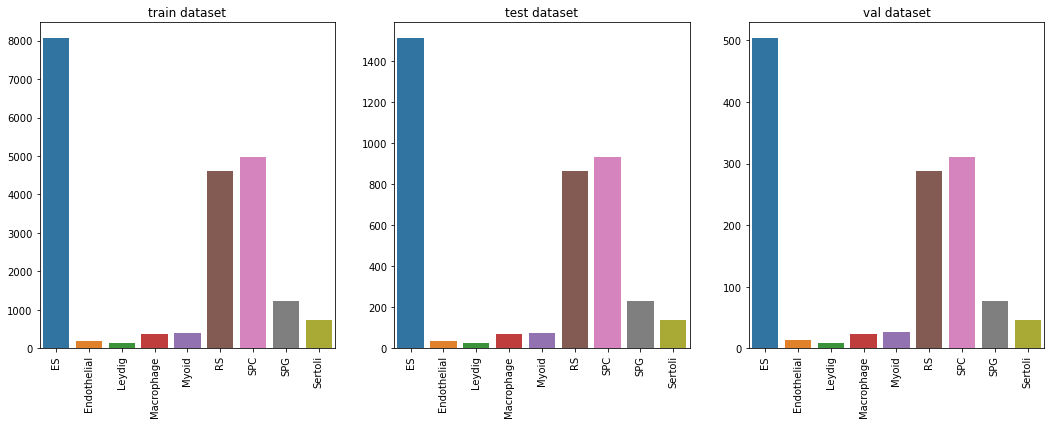

In [13]:
ncols=3
fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols,6))

for c, (dataset, title) in enumerate(zip([train_dataset, test_dataset, val_dataset], ["train dataset", "test dataset", "val dataset"])):
    x = list(dataset.cell_type_mapping.keys())
    y = torch.bincount(dataset.cell_type_ids).numpy()
    _ = seaborn.barplot(x=x, y=y, ax=axes[c])
    x_labels_raw = axes[c].get_xticklabels()
    axes[c].set_xticklabels(labels=x_labels_raw, rotation=90)
    _ = axes[c].set_title(title)

### Example training the gene regression model and testing it 

In [113]:
gr = GeneRegression()
gr.configure_optimizer(optimizer_type='adam', lr=5E-3)

In [115]:
# this will take about 10 minutes on a NVIDIA T4 GPU
# adjust subsample_size_cells and subsample_size_genes to make sure:
# 1. not to run out of GPU memory
# 2. have high GPU utilization

results_test = gr.train_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    test_num_samples=10,
    train_steps=7000,
    train_print_frequency=100,
    use_covariates=False,
    l1_regularization_strength=None,
    l2_regularization_strength=None,
    eps_range=(1.0E-5, 1.0E-2),
    subsample_size_cells=2000,
    subsample_size_genes=None,
    from_scratch=True)

[iter 1]  loss: 22484572048.8906
[iter 100]  loss: 13867220880.8906
[iter 200]  loss: 9518147472.8906
[iter 300]  loss: 7295774608.8906
[iter 400]  loss: 5400906640.8906
[iter 500]  loss: 4179715472.8906
[iter 600]  loss: 3422912912.8906
[iter 700]  loss: 2812182672.8906
[iter 800]  loss: 2375800720.8906
[iter 900]  loss: 2062318992.8906
[iter 1000]  loss: 1711628176.8906
[iter 1100]  loss: 1518815248.8906
[iter 1200]  loss: 1352825744.8906
[iter 1300]  loss: 1198597776.8906
[iter 1400]  loss: 1075772816.8906
[iter 1500]  loss: 947419152.8906
[iter 1600]  loss: 878005776.8906
[iter 1700]  loss: 773315472.8906
[iter 1800]  loss: 702718608.8906
[iter 1900]  loss: 633404688.8906
[iter 2000]  loss: 584238352.8906
[iter 2100]  loss: 532884720.8906
[iter 2200]  loss: 485671632.8906
[iter 2300]  loss: 456479728.8906
[iter 2400]  loss: 403034736.8906
[iter 2500]  loss: 374575216.8906
[iter 2600]  loss: 361072912.8906
[iter 2700]  loss: 321553136.8906
[iter 2800]  loss: 294871504.8906
[iter 290

### check the loss to see if the model has converged

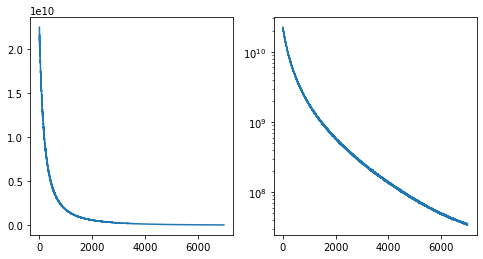

In [122]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr.show_loss(ax=axes[0])
gr.show_loss(ax=axes[1], logy=True)

### if satisfied save the checkpoint else extend the training

[iter 7001]  loss: 34732564.8906
[iter 7100]  loss: 33542988.8906
[iter 7200]  loss: 31992626.8906
[iter 7300]  loss: 31290948.8906
[iter 7400]  loss: 31080882.8906
[iter 7500]  loss: 30256294.8906
[iter 7600]  loss: 28800956.8906
[iter 7700]  loss: 29025930.8906
[iter 7800]  loss: 27909128.8906
[iter 7900]  loss: 27507140.8906
[iter 8000]  loss: 27147872.8906
[iter 8100]  loss: 26865524.8906
[iter 8200]  loss: 26301088.8906
[iter 8300]  loss: 25540514.8906
[iter 8400]  loss: 25646906.8906
[iter 8500]  loss: 25343262.8906
[iter 8600]  loss: 24734406.8906
[iter 8700]  loss: 24776822.8906
[iter 8800]  loss: 24468576.8906
[iter 8900]  loss: 23986438.8906
[iter 9000]  loss: 23801870.8906
[iter 9100]  loss: 23765506.8906
[iter 9200]  loss: 23303684.8906
[iter 9300]  loss: 23291936.8906
[iter 9400]  loss: 22985934.8906
[iter 9500]  loss: 22893792.8906
[iter 9600]  loss: 23122798.8906
[iter 9700]  loss: 22767930.8906
[iter 9800]  loss: 22439406.8906
[iter 9900]  loss: 22335588.8906
[iter 1000

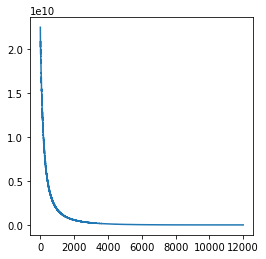

In [125]:
# Here we:
# 1. extend the training for 5000 additional steps
# 2. recheck the loss function
# 3. save the ckpt

results_test = gr.extend_train_and_test(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    test_num_samples=10,
    train_steps=5000,
    train_print_frequency=100,)

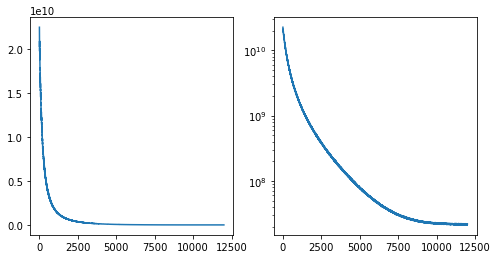

In [126]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr.show_loss(ax=axes[0])
gr.show_loss(ax=axes[1], logy=True)

In [128]:
gr.save_ckpt("no_cov_12k.pt")

# check the (fitted) parameters

In [172]:
df = gr.get_params()
df

,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_0,eps,cell_type,gene
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.463935,0.008367,ES,0610009L18Rik
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.531262,0.008367,ES,1110004E09Rik
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.757833,0.008356,ES,1110017D15Rik
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.247510,0.008361,ES,1110032A03Rik
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.430692,0.008367,ES,1110065P20Rik
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.580337,0.008158,Sertoli,mt-Nd1
14432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.126272,0.008062,Sertoli,mt-Nd2
14433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.315942,0.008076,Sertoli,mt-Nd4
14434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5.655148,0.008200,Sertoli,mt-Rnr1


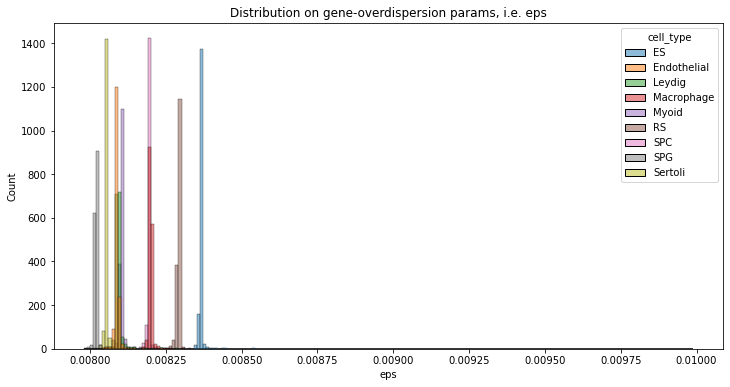

In [173]:
fig, ax = plt.subplots(figsize=(12,6))
_ = seaborn.histplot(data=df, x="eps", hue="cell_type", bins=200, ax=ax, multiple="layer")
_ = ax.set_title("Distribution on gene-overdispersion params, i.e. eps")

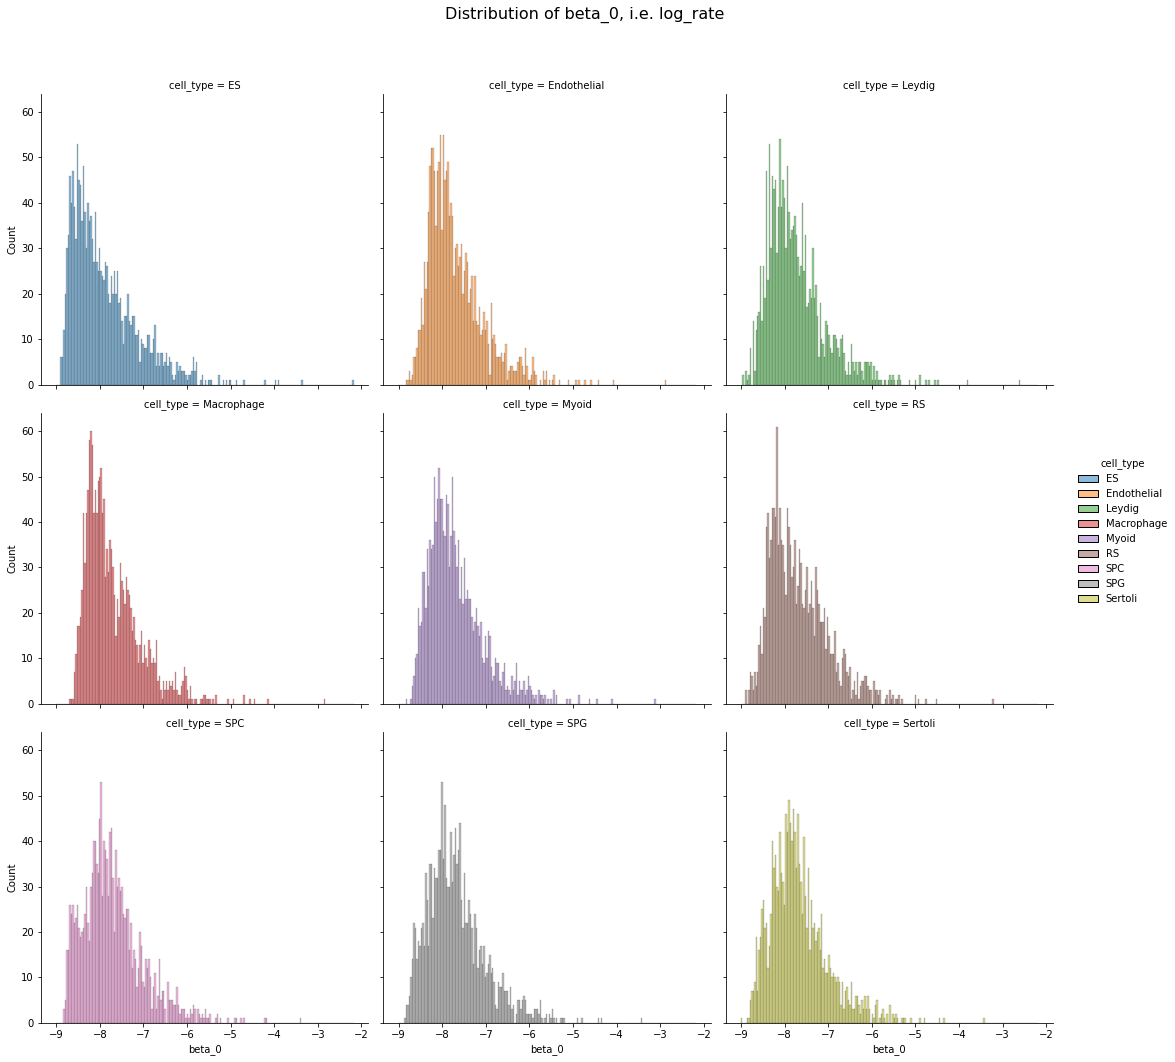

In [184]:
g = seaborn.displot(data=df, x="beta_0", hue="cell_type", col="cell_type", kind='hist', bins=200, common_bins=True, col_wrap=3)
g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("Distribution of beta_0, i.e. log_rate", fontsize=16)

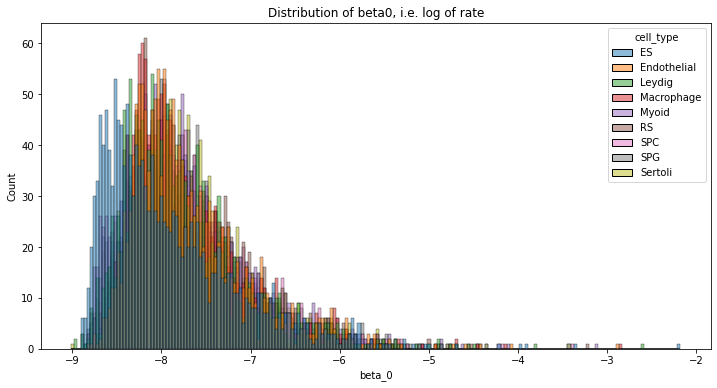

In [175]:
fig, ax = plt.subplots(figsize=(12,6))
_ = seaborn.histplot(data=df, x="beta_0", hue="cell_type", bins=200, ax=ax)
_ = ax.set_title("Distribution of beta0, i.e. log of rate")

# check distribution of highly expressed genes

find the top k highly expressed gene

In [203]:
gene_index = torch.topk(test_dataset.counts.sum(axis=0), axis=-1, k=10)[1]
gene_names = numpy.array(test_dataset.gene_names)[gene_index]
print(gene_index)
print(gene_names)

tensor([1118, 1117, 1444, 1445,  839, 1289, 1012,  898,  717, 1302])
['Prm2' 'Prm1' 'Tnp1' 'Tnp2' 'Ldhc' 'Smcp' 'Odf2' 'Meig1' 'Gsg1' 'Spa17']


In [310]:
df_metric, df_counts = gr.predict(
    dataset=test_dataset,
    num_samples=100,
    subsample_size_cells=400,
    subsample_size_genes=None)

In [311]:
df_just_one_gene = df_counts[df_counts["gene"] == 'Prm2']
df_just_one_gene.head()


,counts_pred,counts_obs,cell_type,gene
1118,46,32,RS,Prm2
2722,7,22,RS,Prm2
4326,42,17,RS,Prm2
5930,12,9,RS,Prm2
7534,236,77,ES,Prm2


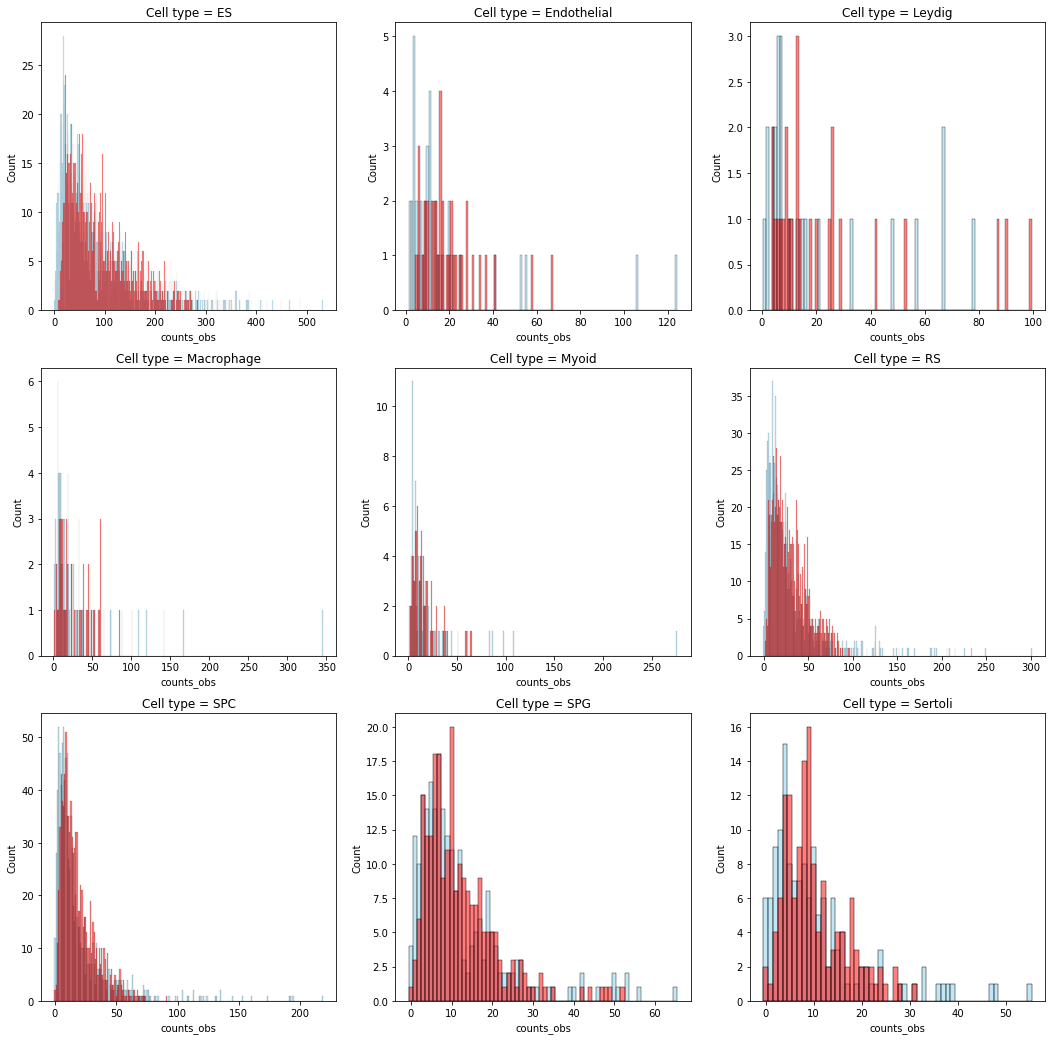

In [312]:
unique_cell_types = numpy.unique(df_just_one_gene["cell_type"].values)
nmax = len(unique_cell_types)
ncols = 3
nrows = int(numpy.ceil(float(nmax)/ncol))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 6*nrows))

for n, cell_type in enumerate(unique_cell_types):
    r,c = n//ncols, n%ncols
    ax_cur = axes[r,c]
    
    df_tmp = df_just_one_gene[ df_just_one_gene["cell_type"] == cell_type]
    # OPTION 1: plot 2 barplots
    _ = seaborn.histplot(data=df_tmp, x="counts_obs", color="skyblue", binwidth=1, alpha=0.5, discrete=True, ax=ax_cur)
    _ = seaborn.histplot(data=df_tmp, x="counts_pred", color="red", binwidth=1, alpha=0.5, discrete=True, ax=ax_cur)  
    
    # OPTION 2: or plot one barplot and one kde
    # _ = seaborn.histplot(data=df_tmp, x="counts_obs", stat="density", color="skyblue", binwidth=1, alpha=1.0, discrete=True, ax=ax_cur)
    # _ = seaborn.kdeplot(data=df_tmp, x="counts_pred", color="red", ax=ax_cur)  
    _ = ax_cur.set_title("Cell type = {}".format(cell_type))   

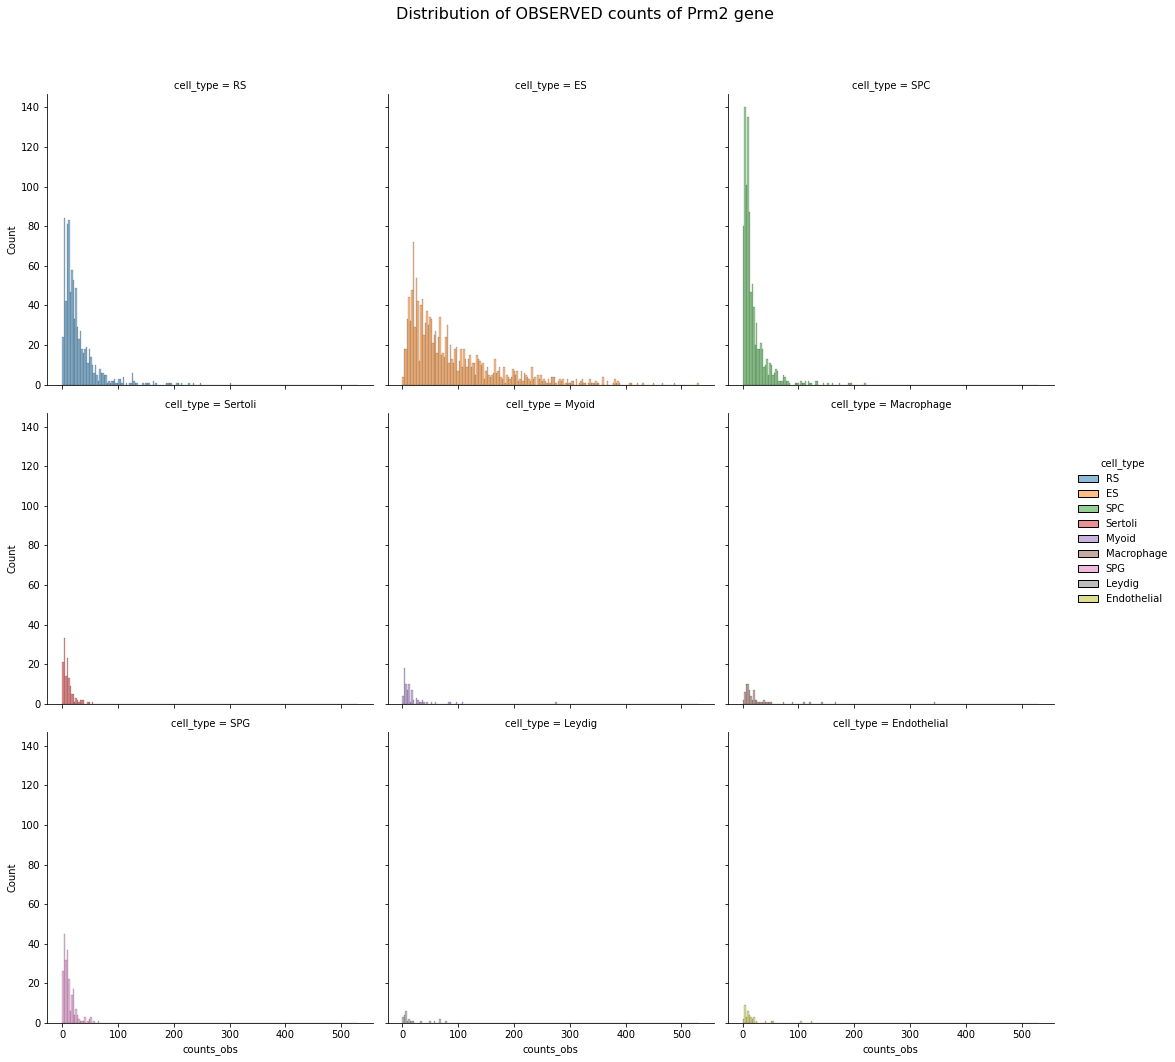

In [313]:
g = seaborn.displot(data=df_just_one_gene, x="counts_obs", hue="cell_type", col="cell_type", kind='hist', bins=200, common_bins=True, col_wrap=3)
g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("Distribution of OBSERVED counts of Prm2 gene", fontsize=16)

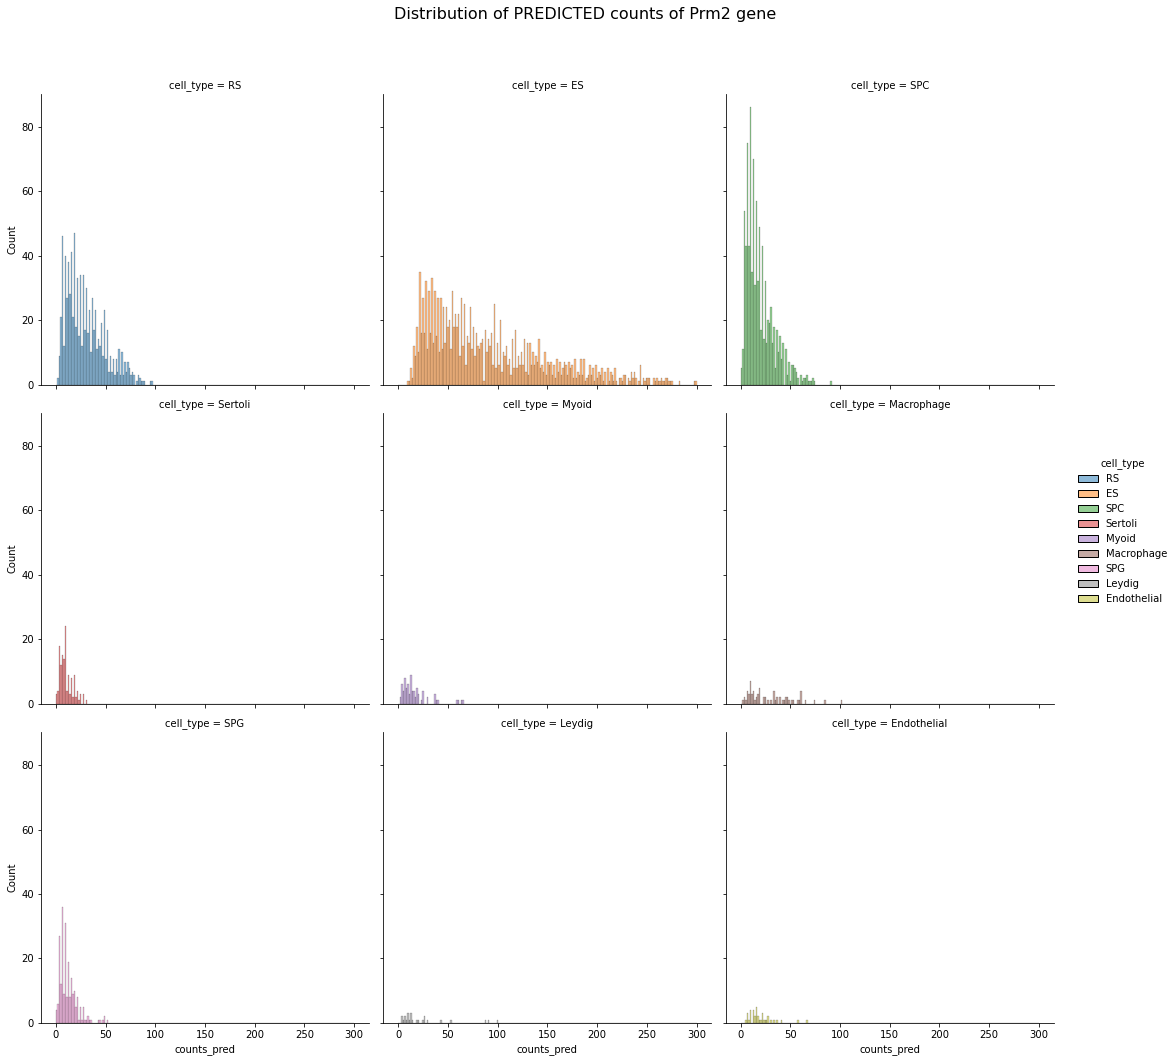

In [314]:
g = seaborn.displot(data=df_just_one_gene, x="counts_pred", hue="cell_type", col="cell_type", kind='hist', bins=200, common_bins=True, col_wrap=3)
g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("Distribution of PREDICTED counts of Prm2 gene", fontsize=16)

# check the metrics

In [315]:
df_metric.head()

,cell_type,gene,q_predictive,q_empirical,log_score
0,ES,0610009L18Rik,0.250033,0.230218,-0.382143
1,ES,1110004E09Rik,0.238302,0.219630,-0.374779
2,ES,1110017D15Rik,0.920330,1.168798,-1.131692
3,ES,1110032A03Rik,0.683699,0.821176,-0.907635
4,ES,1110065P20Rik,0.266651,0.258943,-0.420230


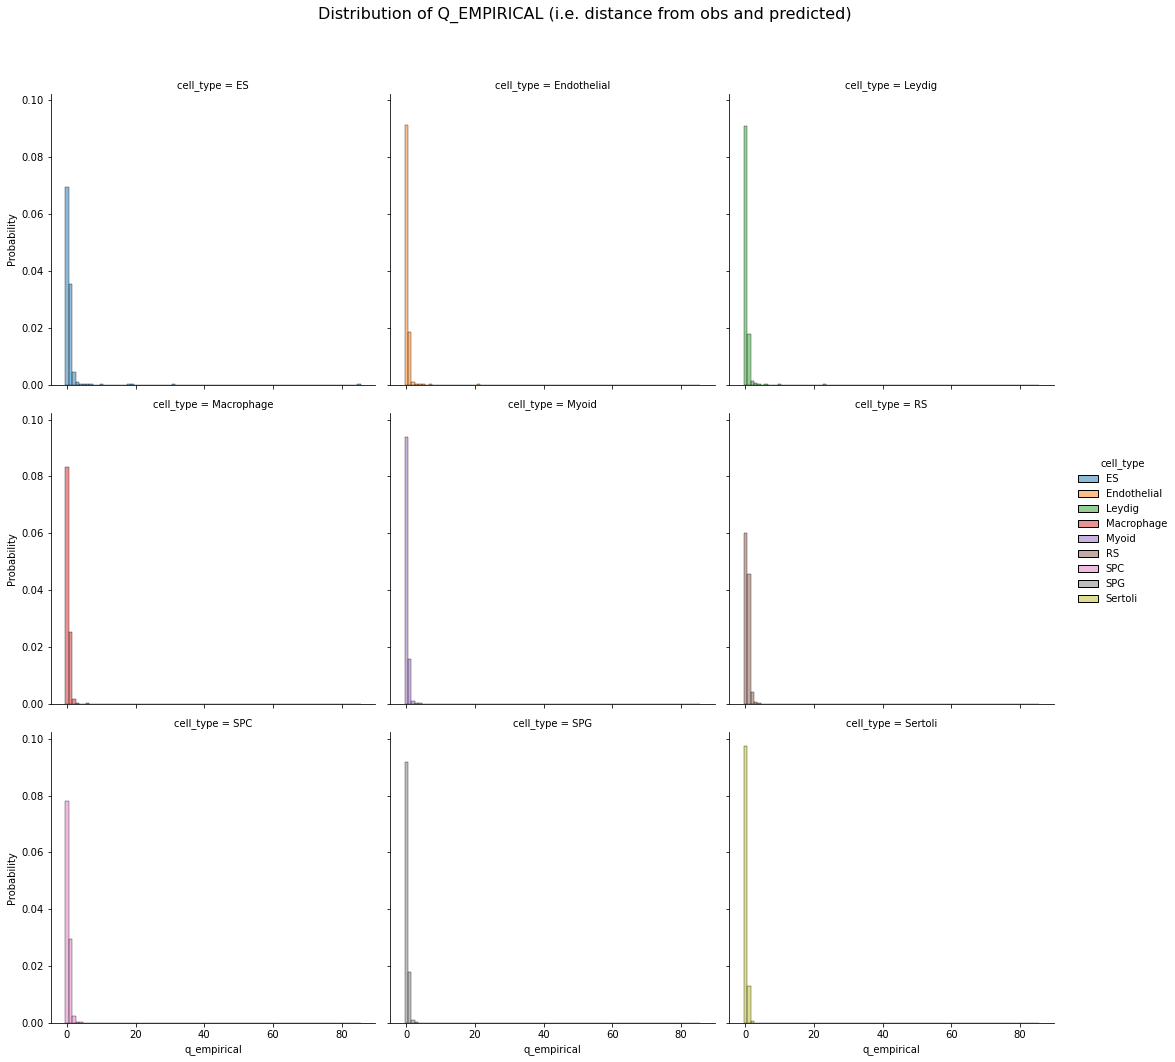

In [316]:
g = seaborn.displot(data=df_metric, x="q_empirical", hue="cell_type", col="cell_type", kind='hist', stat="probability", discrete=True, col_wrap=3)
g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("Distribution of Q_EMPIRICAL (i.e. distance from obs and predicted)", fontsize=16)

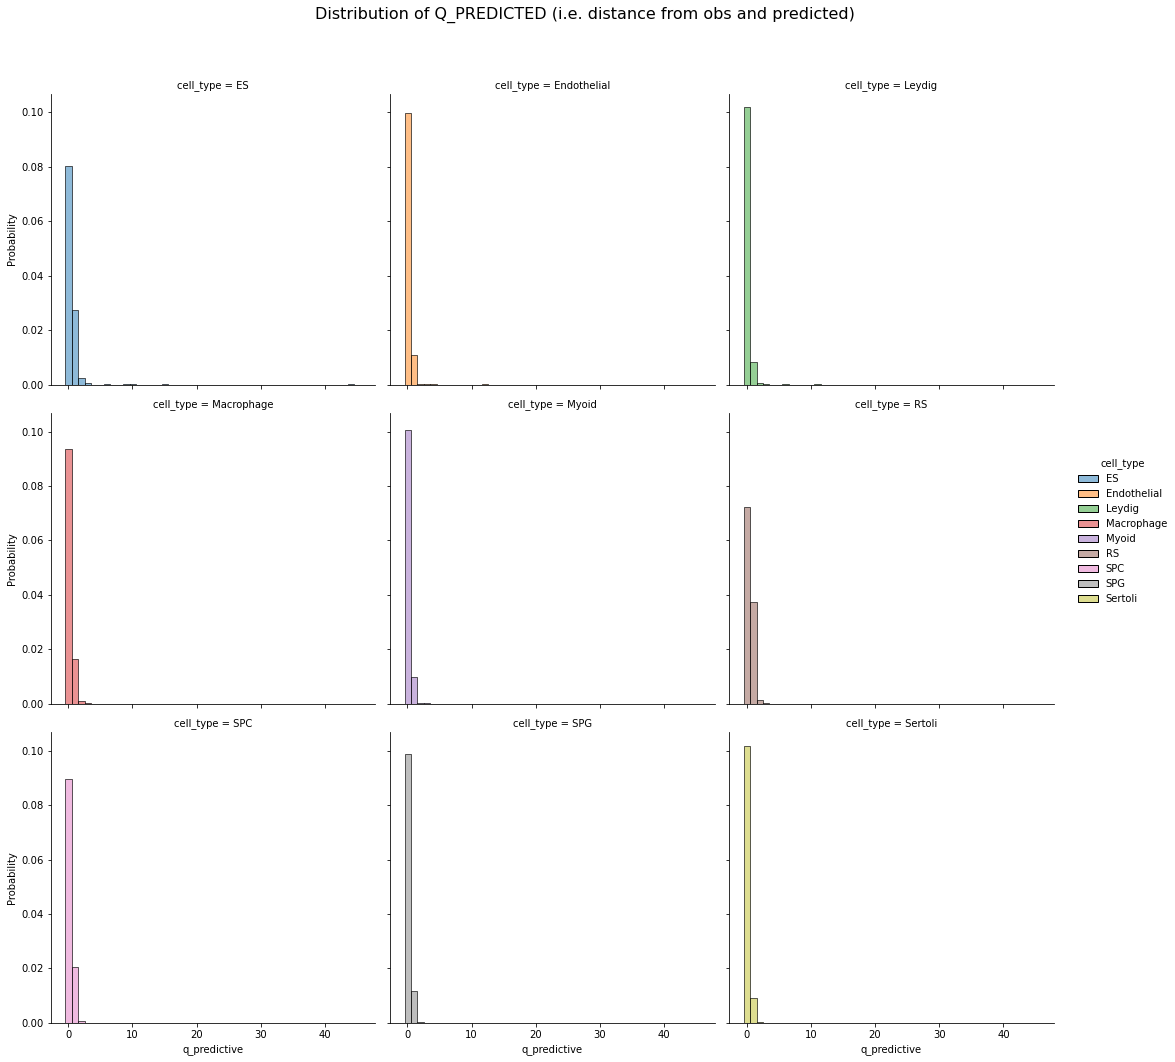

In [317]:
g = seaborn.displot(data=df_metric, x="q_predictive", hue="cell_type", col="cell_type", kind='hist', stat="probability", discrete=True, col_wrap=3)
g.fig.subplots_adjust(top=0.9)
_ = g.fig.suptitle("Distribution of Q_PREDICTED (i.e. distance from obs and predicted)", fontsize=16)

In [318]:
df_metric["q_inv_ratio"] = df_metric["q_empirical"] / df_metric["q_predictive"]
df_metric["q_inv_ratio"].describe()

count    14436.000000
mean         1.041194
std          0.229932
min          0.000000
25%          0.947915
50%          1.065081
75%          1.158377
max          2.437163
Name: q_inv_ratio, dtype: float64

In [319]:
df_metric["q_ratio"] = df_metric["q_predictive"] / df_metric["q_empirical"]
df_metric["q_ratio"].describe()

count    1.443600e+04
mean              inf
std               NaN
min      4.103131e-01
25%      8.632766e-01
50%      9.388957e-01
75%      1.054947e+00
max               inf
Name: q_ratio, dtype: float64

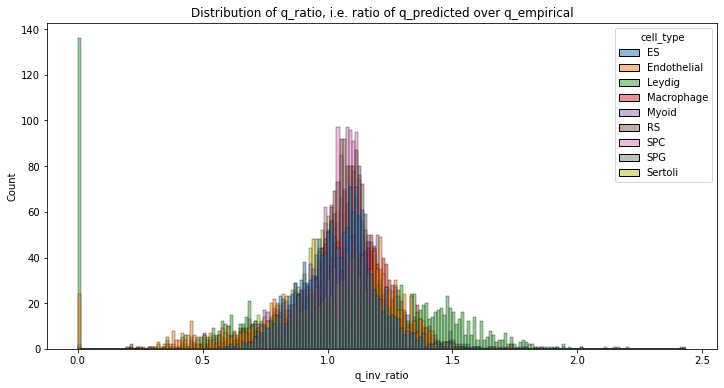

In [320]:
fig, ax = plt.subplots(figsize=(12,6))
_ = seaborn.histplot(data=df_metric, x="q_inv_ratio", hue="cell_type", bins=200, ax=ax)
_ = ax.set_title("Distribution of q_ratio, i.e. ratio of q_predicted over q_empirical")

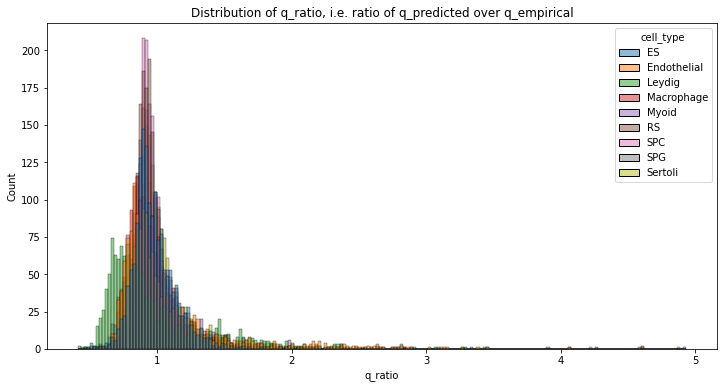

In [321]:
fig, ax = plt.subplots(figsize=(12,6))
_ = seaborn.histplot(data=df_metric, x="q_ratio", hue="cell_type", bins=200, ax=ax)
_ = ax.set_title("Distribution of q_ratio, i.e. ratio of q_predicted over q_empirical")

### visualization

FROM HERE

loop for many l1 and l2 
no_covariate, and covariate.
make plots

In [ ]:
train_dataset.counts[:, 2766]
counts_train_ng[:, 2766]

def scatter_plots_true_pred(cell_types_n, true_counts_n, predicted_counts_n, titles, figsize, ncols):
    unique_cell_labels = numpy.unique(cell_types_n)
    
fig, axes = plt.subplots(ncols

_ = seaborn.scatterplot(x=train_dataset.counts[:, 2766], y=counts_train_ng[:, 2766], col=train_dataset.cell_type_ids)

In [ ]:
plot_gene_hist(train_dataset.cell_type_ids, train_dataset.counts[:, gene_index[:3]], counts_train_ng[:, gene_index[:3]], bins=20)



### Find a highly expressed gene

In [ ]:
torch.topk(train_dataset.counts.sum(axis=0), axis=-1, k=20)

In [ ]:
plot_gene_hist(train_dataset.cell_type_ids, train_dataset.counts[:, :2], counts_train_ng[:, :2], bins=20)

In [ ]:
q_train_df

In [ ]:
plt.imshow(q_test[:,:100])

In [ ]:
plt.imshow(q_train[:,:100])

In [ ]:
plt.plot(torch.mean(q_test/q_train, dim=1))

In [ ]:
plt.plot(torch.mean(q_test/q_train, dim=0))

In [ ]:
plt.imshow(q_train[:,:100])

In [ ]:
plt.imshow(q_test[:,:100])

In [ ]:
plt.imshow(q_data[:,:100])

In [ ]:
assert 1==2

In [ ]:
logq, q, q_data = results_test

In [ ]:
plt.imshow(q_data[:,:100])

In [ ]:
q_data/q

In [ ]:
plt.imshow(q[:,:100])

In [ ]:
plt.imshow(logq[:,:100])

In [ ]:
results_train = gr.predict(
    dataset=train_dataset,
    num_samples=10,
    subsample_size_cells=400,
    subsample_size_genes=400)

In [ ]:
df0, df1, df2 = result

In [ ]:
df2

### visualize the results